In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.special import erf

# Antenna Theory and Dipoles

An electric dipole moment is when 2 charges are separated by some distance, and one charge is negative and the other is positive. The charge of the entire dipole is neutral. They are separated by a fixed distance $l$.

They can be represented by the "electric dipole vector" or more commonly known as the electric dipole moment. This moment $\vec{p}$ points in the direction from the negative charge to the positive charge, and has magnitude defined as $p = Ql$ where $Q$ is the magnitude of each charge and $l$ is the distance separating the charges.

The electric field produced by the dipole is directional and unique. The electric field lines emerge from the positive charge and converge at the negative charge. This creates a pattern of extending outwards and then looping back in on itself.

The equations derived below come from fundamentals of applied electromagnetics, seventh edition

A hertzian dipole is a short dipole where the current is considered constant over the entire antenna. To find the electric and magnetic fields at a point Q in space due to radiation from a source, the retarded vector potential A must be calculated. 

A retarded potential are the electromagnetic potentials for an electromagnetic field generated by a time-varying electric current.

A phasor is a complex number representing a sinusoidal function whose amplitude (A) and phase ($\theta$) are time invariant and whose angular frequency ($\omega$) is fixed.

\begin{align}
\tilde{\textbf{A}}(\textbf{R}) = \frac{\mu_0}{4\pi}\int_{v'}\frac{\tilde{J}e^{-jkR'}}{R'}dv'
\end{align}

$\mu_0$: magnetic permeability (how easily a material can be magnetized) of free space

$\textbf{R}$: distance vector from a volume $\tilde{\textbf{v}}$

$\tilde{\textbf{J}}$: phasor current distribution contained in $\tilde{\textbf{v}}$

$k = \frac{2\pi}{\lambda}$: the wave number


$\tilde{\textbf{J}}$ can be simplified to $\hat{\textbf{z}}(\frac{I_0}{s})$ where $\hat{\textbf{z}}$ is the unit vector along the z axis and s is the cross-sectional area of the dipole wire. By replacing $d\textbf{tilde{v}}$ with $s dz$, we can simplify the integral and then solve it analytically to get:

\begin{align}
\tilde{\textbf{A}} = \hat{\textbf{z}}\frac{\mu_0}{4\pi}I_0l\frac{e^{-jkR}}{R}
\end{align}

To visualize the attenna pattern plots, we must convert the vector potential to spherical coordinates. This is done by using the identity $\hat{\textbf{z}} = \hat{\textbf{R}}cos(\theta) - \hat{\theta}sin(\theta)$

Incorporating this into the phasor retarded vector potential and then using the free-space relationships

\begin{align}
\tilde{\textbf{H}} = \frac{1}{\mu_0}\nabla\times\tilde{\textbf{A}}\newline
\tilde{\textbf{E}} = \frac{1}{j\omega\epsilon_0}\nabla\times\tilde{\textbf{H}}
\end{align}

That results in the calculations of $tilde{H_\phi}$, $\tilde{E_R}$, $\tilde{E_\theta}$, where $\textbf{H}$ is the magnetic field, and $\textbf{E}$ are the electric fields.

The calculations of these values are provided in the code below

In [165]:
def hertzian_dipole(λ,θ,R,I0,l):
    """λ: wavelength of the dipole 
       θ: zenith angle of the hertzian dipole, as the field with respect to the azimuth angle is 0
       R: Distance between observation point and center of short dipole
       I0: current amplitude 
       l: the length of the linear conductor (l <= λ/50)
       """
    #create a grid to calulate the range and zenith angle
    R,θ=np.meshgrid(R,θ)
    
    #define the wave number and spherical propagation factor
    k = (2*np.pi)/λ
    phase_change = np.exp(-1j*k*R)
    
    #calculate the intrinsic impedance of free space
    η_0 = 120*np.pi
    
    coeff = (I0*l*k**2)/(4*np.pi)
    
    #calculate the electric field waves and magnetic fields in spherical coordinates
    E_R = 2*coeff*η_0*phase_change*(1/(k*R)**2 - 1j/(k*R)**3)*np.cos(θ)
    E_θ = coeff*η_0*phase_change*(1j/(k*R) + 1/(k*R)**2 - 1j/(k*R)**3)*np.sin(θ)
    H_φ = coeff*phase_change*(1j/(k*R) + 1/(k*R)**2)*np.sin(θ)
    
    return E_R,E_θ,H_φ

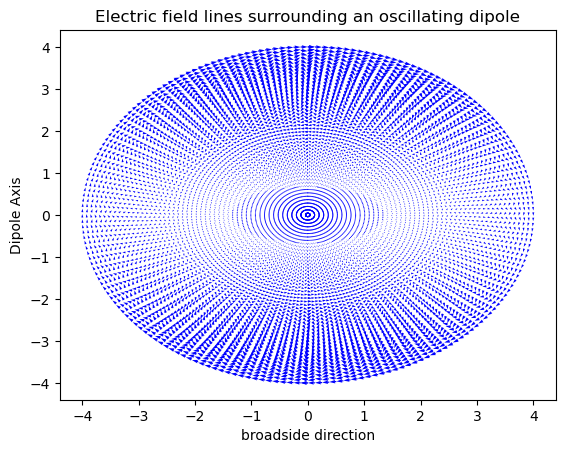

In [166]:
λ = 1
θ = np.linspace(-2*np.pi,2*np.pi,100)
l = 1/100
R = np.linspace(-4,4,100)
I0 = 10

#find the electric and magnetic fields
E_R,E_θ,H_φ = hertzian_dipole(λ, θ,l,R,I0)

#convert the electric fields to cartesian coordinates
E_x = E_R*np.sin(θ) + E_θ*np.cos(θ)
E_z = E_R*np.cos(θ) - E_θ*np.sin(θ)
R,θ=np.meshgrid(R,θ)

#display the electric field lines
plt.quiver(R*np.sin(θ),R*np.cos(θ),E_x, E_z, color = 'blue')
plt.title('Electric field lines surrounding an oscillating dipole')
plt.xlabel('broadside direction')
plt.ylabel('Dipole Axis')
plt.show()

# Antenna Radiation

An Antenna pattern describes the far-field directional properties of an antenna when measured at a fixed distance from the antenna. It can bevisualized by displaying the strength of the radiated field/power density as a function of direcion. The directions being the zenith angle and azimuth angle.

The normalized radiation intensity is defined as $F(\theta, \phi)$, which is the ratio of the power density $S(R,\theta, \phi)$ at a specified range $R$ to $S_{max}$, which is the maximum value of the power density $S$ at the same range $R$.

\begin{align}
F(\theta, \phi) = \frac{S(R,\theta, \phi)}{S_{max}}
\end{align}

In [81]:
def radiation_intensity(θ, φ, P_in,G):
    """
    θ: zenith angle
    φ: aximuthal angle
    P_in: input power to the antenna
    G: gain function in terms of θ,φ
    """
    S = (P_in * G(θ, φ))/(4*np.pi)
    S_max = np.max(S)
    
    #return the normalized value to get the radiation intensity
    return S/S_max

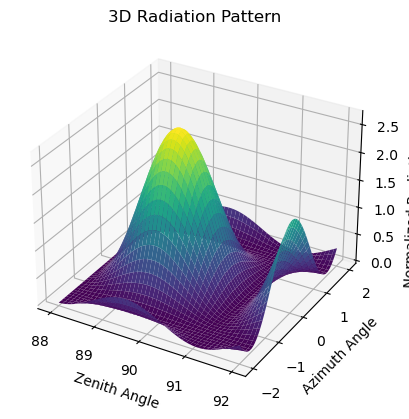

In [82]:
theta = np.linspace(88,92,180)
phi = np.linspace(-2,2,180)
P_in = 100
θ, φ = np.meshgrid(theta, phi)
G = lambda theta,phi: 3*np.sin(theta)**2 * -6*np.cos(phi)**2
F = radiation_intensity(θ, φ, P_in, G)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(θ, φ, F, cmap='viridis')
ax.set_title('3D Radiation Pattern')
ax.set_xlabel('Zenith Angle')
ax.set_ylabel('Azimuth Angle')
ax.set_zlabel('Normalized Radiation intensity')
plt.show()

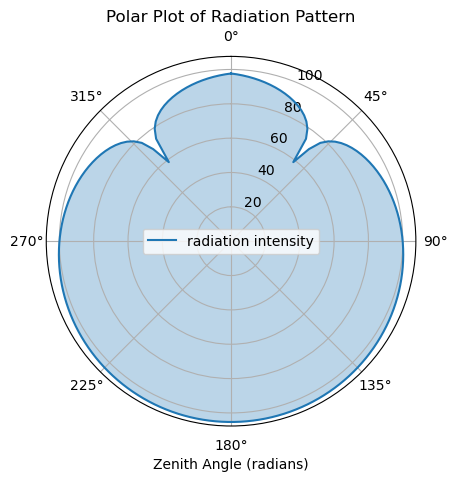

In [83]:
#possible zenith angle
θ = np.linspace(0, 2*np.pi, 180)  # Zenith angles from 0 to π

# Convert intensity to decibels and consider only the values of theta
intensity_db = (10 * np.log10(F))[:,0]

# Polar plot
plt.figure()
ax = plt.subplot(111, polar=True)
ax.plot(θ, intensity_db, label = 'radiation intensity')
ax.fill(θ, intensity_db, alpha=0.3)  # Fill under the curve
ax.set_theta_zero_location('N')  # Set the zero of the angle coordinates to the top of the circle
ax.set_theta_direction(-1)  # Set the angle increase clockwise
ax.set_title('Polar Plot of Radiation Pattern')
ax.set_xlabel('Zenith Angle (radians)')
ax.legend()
plt.show()


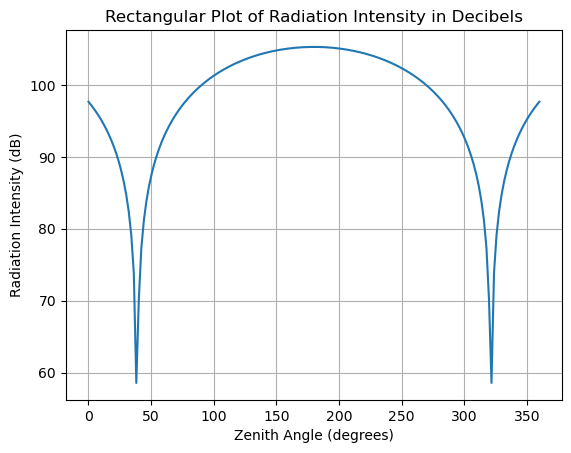

In [84]:
# Rectangular plot
plt.figure()

#plot the normalized radiation density on a decibel scale against degrees
plt.plot(θ * 180 / np.pi, intensity_db)
plt.title('Rectangular Plot of Radiation Intensity in Decibels')
plt.xlabel('Zenith Angle (degrees)')
plt.ylabel('Radiation Intensity (dB)')
plt.grid(True)
plt.show()


# Information from 'Alignment-Free Coupling to Arrays of Diamond Microdisk Cavities for Scalable Spin-Photon Interfaces'

# Figure of Merit η

$$\eta = \eta_{zpl}\cdot\eta_{col}$$
$\eta$ is the probability that the excited state of an emitter results in a photon deteced in the zero-photon-line (ZPL).


where $\eta_{zpl}$ is the probability of emission of light into the ZPL, and $\eta_{col}$ is the probability of emission of light into the desired mode (whispering gallery mode within the diamond microdisk).

# Quality Factor of an Optical Resonator

https://www.rp-photonics.com/q_factor.html

https://en.wikipedia.org/wiki/Q_factor#:~:text=It%20is%20defined%20as%20the,to%20an%20oscillating%20driving%20force.

The quality factor Q measures how well the chosen medium and device can store energy. A higher Q factor indicates that oscillations of light can be sustained for long periods of time before the light is absored into or escapes from the cavity.

The Q factor of an optical resonator (such as a microdisk resonator as used in Helaman Flores' and Dr. Camacho's paper), depends on a few variables. That is

\begin{align}
Q = \frac{2\pi\nu_0T_{rt}}{l}
\end{align}

where $\nu_0$ is the resonant frequency of the device, $l$ is the fractional power loss per round trip and $T_{rt}$ is the round trip time of light in the cavity.

$T_{rt} = \frac{2\pi r}{c_n}$
Where r is the radius of the microdisk, and c_n is the speed of light in the chosen medium. 
$c_n = \frac{c}{n}$ where c is the speed of light in a vacuum and n is the refractive index of the microdisk material

In [4]:
p = 2 * np.pi * 1e-6 #radius of one micron, calculate perimeter length of disk
c_n = 3e8/2.41 #speed of light divided by the refractive index of diamond
T = p/c_n

ν = (3e8*2.41)/500e-9

print(f'The time to complete one oscillation in the device is:{T}')

The time to complete one oscillation in the device is:5.047492196767601e-14


In [5]:
def q_factor(ν,Τ,l):
    """ν: the resonant frequency of the quantum device 
       T: the amount of time it takes to complete one oscillation
       l: the amount of power/energy loss per oscillation (absorbed into the medium or escaping)"""
    return (2*np.pi*ν*T)/l

In [15]:
l = 0.01
Q = q_factor(ν, T, l)
print(f'The Quality factor Q of a device with a hypothetical loss of {l} is: {Q}')

The Quality factor Q of a device with a hypothetical loss of 0.01 is: 45858.919457573684


# Purcell Enhancement

https://optics.ansys.com/hc/en-us/articles/360041612594-Purcell-factor-of-a-microdisk 

The Purcell Enhancement is the power emitted by the dipole source in a specific environment divided by the power emitted by the dipole in a homogeneous environment (free space). You confine the within a cavity, which restricts the available modes of the electromagnetic fields. The cavity contains a resonant mode (specific electromagnetic field patterns that satisfy the boundary conditions of the cavity structure), and with a higher Purcell factor, there's a higher probability of emission into that mode.

In [16]:
def purcell_enhance(λ, Q, V,n):
    """λ: wavelength of the emitted light in a vacuum
       Q: the quality factor, describes how underdamped the resonator is
       V: the mode volume
       n: Refractive index of the medium chosen"""
    return 3/(4*np.pi**2)*(λ/n)**3*(Q/V)

In [17]:
F_p = purcell_enhance(500e-9, Q, 0.1, 2.41)
F_p

3.1120331950207465e-16

# $\eta_{zpl}$ the proportion of emissions into the ZPL

ZPL: Zero Phonon Line. This is the energy difference between the excited state and the ground state. A phonon is a discrete unit of vibrational energy in a crystal lattice. The ZPL refers to an emission or absorption line, where there is a complete energy transfer between states without the interactions of phonons

In [25]:
def eta_zpl(F, Γ_total, Γ_zpl):
    """F: the purcell enhancement of the device at the targeted wavelength λ
       Γ_total: total unmodified emission rate of color center
       Γ_zpl: ZPL emission rate of chosen color center"""
    
    return F/(F + (Γ_total/Γ_zpl - 1))

# $\eta_{col}$ collection efficiency of emissions into desired mode

We desire to know how much light is being emitted into the mode with the highest Q factor. In the case of the diamond microdisk, this is the whispering gallery mode, where the light will be trapped within the resonator and circle around the perimeter until absorbed into the cavity or emitted into the far field.

$\eta_{col}$ is as radial power in the far field collected into numerical apertures (NA) less than 0.7. Numerical Apertures is a dimensionless number that characterizes the range of angles over which the system can accept or emit light. 

It can be calculated by: $NA = n\sin(\theta)$

n - refractive index of the medium in which the fiber is working

$\theta$ - half-angle of the maximum cone of light that can enter or exit the optic fiber

In reference to a quantum emitter, it refers to how well light can be coupled within the emitter or be collected in an optic fiber. 

# Construct and simulate the desired optical device


This simulation requires MIT's open source MEEP. This was setup on linux through BYU's supercomputer. We construct a device that is a diamond microdisk, with a silicone-nitride grating layer with a hexadiagonal grid of scattering holes that each act as an individual dipoles (will write up a section on dipoles). On top is a glass substrate. We will construct the device, and display the geometry. We assume a tin color center (will write up a section on color centers to better understand them), and display the electric field of a diamon microdisk without the grating layer and with the grating layer

In [23]:
import meep as mp

def meep_sim():
    """Recreate the simulations from Lumerical that Helaman and Ryan generated in the paper that they published together"""
    
    #set up the geometry for the diamond microdisk
    geometry =[]
    microdisk_radius = 1.5427
    microdisk_material = mp.Medium(index = 2.41)
    geometry.append(mp.Cylinder(radius = microdisk_radius, material = microdisk_material, center = mp.Vector3(0,0,0),height = 0.9411))

    #define the cell x,y and z components with a PML layer of 1
    sxy = 6
    sz = 5
    cell_size = mp.Vector3(sxy, sxy, sz)
    pml_layers = [mp.PML(1.0)]
    
    #define the silicone nitride slab
    silicon_nitride_thickness = 0.2931
    silicon_nitride_z_center = 0.9411/2 + silicon_nitride_thickness / 2
    block_size = cell_size
    block_material = mp.Medium(index = 1.8)
    geometry.append(mp.Block(mp.Vector3(sxy,sxy,silicon_nitride_thickness), center = mp.Vector3(0,0, silicon_nitride_z_center), material = block_material))

    #define the number of holes you want in your scattering grid and the spacing between them
    n_rows = 12
    n_cols = 12
    spacing = 0.5168

    #define the radius of the hole and set them as air
    hole_radius = .2
    hole_material = mp.Medium(index = 1)
    
    #iterate through all possible locations of holes and create geometry for each of them
    for i in range(-n_rows//2, n_rows//2+1):
        for j in range(-n_cols//2, n_cols//2+1):
            x_adjust = spacing / 2 if i % 2 == 0 else 0
            #define the x and y position of the scattered holes
            x_p = j*spacing + x_adjust 
            y_p=i*spacing*np.sqrt(3)/2

            #create the geometry for the holes
            geometry.append(mp.Cylinder(radius = hole_radius, material = hole_material, 
                    center = mp.Vector3(x_p,y_p,silicon_nitride_z_center), height = 0.2931))

        #even = not even

    # Define glass substrate properties
    glass_thickness = 0.25  # Example thickness
    glass_material = mp.Medium(index=1.4)

    # Calculate the center position of the glass substrate in Z
    glass_z_center = 0.9411/2 + silicon_nitride_thickness+ glass_thickness/2

    # Add the glass substrate to the geometry
    geometry.append(mp.Block(
    size=mp.Vector3(sxy, sxy, glass_thickness),
    center=mp.Vector3(0, 0, glass_z_center),
    material=glass_material))


    fcen = 1/0.637
    df = 0.01
    source = [mp.Source(src = mp.GaussianSource(fcen, fwidth = df), component = mp.Ey, center = mp.Vector3(0, microdisk_radius*0.96, 0.0))]

    resolution = 25

    sim = mp.Simulation(cell_size = cell_size,
                            boundary_layers = pml_layers, 
                            geometry = geometry, 
                            sources = source, 
                            resolution = resolution)

    sim_duration = 1000

    efield_monitor = sim.add_dft_fields([mp.Ez], fcen-df/2, fcen+df/2, 1, 
                                where = mp.Volume(center = mp.Vector3(0,0,0), size = mp.Vector3(sxy,sxy,0)))

    sim.run(until = sim_duration)


    ez_data = sim.get_dft_array(efield_monitor, mp.Ez, 0)

    #plot the geometry of the grating layer with the diamond microdisk
    # Plot the geometry xy
    sim.init_sim()
    plt.figure()
    plt.subplot(1, 2, 1)
    sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(sxy, sxy,0)))
    plt.title('xy plane')

    # Plot the geometry xz
    plt.subplot(1, 2, 2)
    sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(sxy, 0, sz)))
    plt.title('xz plane')
    plt.tight_layout()
    if mp.am_really_master():
        plt.savefig("out/geometry")
    plt.show()
    
    ez_data = sim.get_dft_array(efield_monitor, mp.Ez, 0)

    plt.figure(figsize = (8,6))
    plt.imshow(np.abs(ez_data)**2, interpolation = 'spline36', cmap = 'viridis')
    plt.colorbar()
    plt.title('|Ez|^2 in X-Y plane')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.savefig('out/electric_field')
    plt.show()


meep_sim()

The Near field of just a diamond microdisk

![Far Field of Diamon Microdisk](ef_data.png)

Geometry of the device presented in 'Alignment-Free Coupling to Arrays of Diamond Microdisk Cavities for Scalable Spin-Photon Interfaces'

![Geometry of Device](geometry.png)

Near Field of the device

![Near Field of Device](electric_field.png)

# Dipole Model of FDTD Simulations

Meep and Lumerical are used to simulate nano-optical devices, providing a platform where the geometry of these quantum devices can be created and tested. They run off of FDTD simulations, or Finite-Difference Time-Domain Methods. This is a grid based numerical method for finding solutions to Maxwell's Equations.

The electric field E, and magnetic field H are calculated along a mesh composed of $\Delta x$, $\Delta y$ and $\Delta z$, where E and H are interlaced in all 3 spatial dimensions. This is because the change in E in time is dependent on the change in H across space.

These simulations can be computationally expensive if a high resolution is requested, making it difficult to large amounts of simulations of one device. To fix this problem, you can approximate the electric field of each hole in the grating layer as a dipole, and sum over the array of dipoles.

Then:

\begin{align}
E_{ff}(r) = \frac{\eta lk}{4\pi j}\sum_{n=0}^N \frac{e^{-jk|r - r_n'|}}{|r - r_n'|}[(I_{nx}cos(\theta)cos(\phi) + I_{ny}cos(\theta)sin(\phi) - I_{nz}sin(\theta))\hat{\mathbf{θ}} + (-I_{nx}sin(\phi) + I_{ny}cos(\phi))\hat{\mathbf{φ}}]
\end{align}

And the poynting vector is:
\begin{align}
S_{ff} = \frac{|E_{ff}|^{2}}{\eta}\hat{\mathbf{r}}
\end{align}

You use the dipole model simulations by cloning into the camacholab github color-center repository, and in the path
src/dipy/dipy you run:

pip install -e .

It's recommend you create a separate conda environment as the requirement.txt has specific dependendencies in order to run and install all the correct packages.

The repository contains one simplified FDTD simulation of a nearfield to be used in the calculation of the dipole model far field. 

Below is some example test code that can be modified to create varying far-field emission plots

In [2]:
import sys
import dipy as dp
import time
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import minimize

In [ ]:
# Define the parameters of the simulation
wavelength = .673e-6      # frequency of light  baseline: 1/.6454
n = 1.4           # index of refraction baseline: 1.4
# Hexagonal Grid Structure
n_rows = 12                    # number of rows in the grid      baseline: 12
n_cols = 12                      # number of columns in the grid   baseline: 12
spacing = .33e-6                    # spacing between dipoles         baseline: .33
align = np.array([1*spacing/2,0,0])
scattering_centers = dp.hexagonal_grid(n_rows, n_cols, align, spacing)


# Instantiate the simulation
sim = dp.DipoleSimulation(background_index=1.4)

# Create and add the nearfield
nearfield_default = dp.load_nearfield(file_name='matfiles/control_E_nearfield.mat', grid_id ='E', x_id = 'x', y_id = 'y')
nearfield_default.set_resolution(100)
sim.add_nearfield(nearfield_default, "control_nearfield")

scatterers = [dp.ScatteringPoint(pos) for pos in scattering_centers]

# Create and add the dipole grid
sim.add_scatterers(scatterers)

# Run the simulation and plot the farfield
ff = sim.get_farfield(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
dp.plotfarfield_2D(ff, theta=sim.theta, phi=sim.phi, ring30 = False, ring70 = False, save_file="test_basic_farfield1")

Far field pattern of a dipole scatterer with a 12x12 Hexagonal grid with a spacing of .33 microns

![Far Field of Dipole Model](test_basic_farfield1.png)

Far field of dipole scatterer with a 20x20 grid spaced 4 microns apart

![Far Field of Dipole Model](test_basic_farfield.png)

# Find standard deviation for which a gaussian beam has 90% emission efficiency into the ZPL

In [32]:
target_efficiency = 0.9
theta_center = 30

theta_range = 20
def collection(sigma):
    first = erf((theta_center + theta_range)/sigma)
    second = erf((theta_center-theta_range)/sigma)
    return first-second-target_efficiency*2

initial_sigma = 5
sol = fsolve(collection,initial_sigma)
print(f'sigma for 90% collection efficiency is: {sol[0]}')

sigma for 90% collection efficiency is: 38.66813367601061


# Possible Optimization Techniques we can use

We could use stochastic gradient descent with a learning rate that's dependent on time using Jax's adam optimizer. I'm currently running into issues where the far field calculation isn't inherently dependent on the disk thickness, hole spacing, etc, but rather the near_field calcuations are. I'll need to better review Helaman's code to adjust what my setup is below because as it currently is, the loss will never approach zero because we're not varying any of the parameters that change the near_field coefficients.

In [4]:
import jax
import jax.numpy as jnp
import optax

def far_field(params, theta, phi, eta, l, k, r, r_n):
    """
    Calculate the far-field E_ff(r).
    
    Parameters:
    eta (float): Characteristic impedance
    l (float): Length parameter
    k (float): Wave number
    r (float): Distance to far-field point
    theta (float): Theta angle in radians
    phi (float): Phi angle in radians
    r_n (list): List of position of dipole scatterers
    
    Returns:
    jnp.ndarray: Far-field computation
    """
    # These are used to calculate the nearfield coefficients of the dipole scatterers
    a, r_h, t, u, v, r_d, n_g = params
    
    # Examples of near_field coefficients 
    I_nx, I_ny, I_nz = jnp.array([0.3, 0.4]), jnp.array([0.3, 0.4]), jnp.array([0.3, 0.4])
    
    N = len(I_nx)
    
    E_theta = 0
    E_phi = 0
    
    for n in range(N):
        r_nx, r_ny, r_nz = r_n[n]
        r_vec = jnp.array([r, 0, 0]) - jnp.array([r_nx, r_ny, r_nz])
        r_magnitude = jnp.linalg.norm(r_vec)
        
        exp_term = jnp.exp(-1j * k * r_magnitude) / r_magnitude
        
        E_theta += exp_term * (I_nx[n] * jnp.cos(theta) * jnp.cos(phi) + I_ny[n] * jnp.cos(theta) * jnp.sin(phi) - I_nz[n] * jnp.sin(theta))
        E_phi += exp_term * (-I_nx[n] * jnp.sin(phi) + I_ny[n] * jnp.cos(phi))
    
    prefactor = eta * l * k / (4 * jnp.pi * 1j)
    
    E_theta *= prefactor
    E_phi *= prefactor
    
    return jnp.abs(E_theta)**2 + jnp.abs(E_phi)**2

def gaussian_beam(theta, I_0, theta_0):
    """
    Calculate the far-field intensity of a Gaussian beam.
    
    Parameters:
    theta (float or jnp.ndarray): Angle(s) at which to calculate the intensity (in radians).
    I_0 (float): Peak intensity at theta = 0.
    theta_0 (float): Angular width parameter (in radians).
    
    Returns:
    float or jnp.ndarray: Intensity at the given angle(s).
    """
    return I_0 * jnp.exp(-2 * jnp.sin(theta)**2 / theta_0**2)

# Define the loss function
def loss_function(params):
    eta = 0.377  
    l = 1.0
    k = 2 * jnp.pi / 0.637  
    r = 10.0 
    theta_vals = jnp.linspace(0, jnp.pi, 100)
    phi_vals = jnp.linspace(0, 2 * jnp.pi, 100)
    theta, phi = jnp.meshgrid(theta_vals, phi_vals)
    
    r_n = [(0, 0, 0), (1, 1, 1)]  # Example positions of dipole scatterers
    
    far_field_intensity = far_field(params, theta, phi, eta, l, k, r, r_n)
    gaussian_intensity = gaussian_beam(theta, 1.0, jnp.radians(10))
    
    difference = (far_field_intensity - gaussian_intensity)**2
    loss = jnp.trapezoid(jnp.trapezoid(difference, phi_vals), theta_vals)
    return loss

# Initialize parameters
params = jnp.array([0.52, 0.2, 0.94, 0, 0, 1.54, 1.8])

# Define the optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

# Define the update step
@jax.jit
def update(params, opt_state):
    loss, grads = jax.value_and_grad(loss_function)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training loop
num_iterations = 1000
for t in range(1, num_iterations + 1):
    params, opt_state, current_loss = update(params, opt_state)
    
    # Optional: Print progress
    if t % 100 == 0:
        print(f"Iteration {t}: Loss = {current_loss}, Params = {params}")

# Output results
print("Optimized Parameters:", params)
print("Minimum Loss:", loss_function(params))

Iteration 100: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 200: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 300: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 400: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 500: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 600: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 700: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 800: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 900: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Iteration 1000: Loss = 0.9733705520629883, Params = [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Optimized Parameters: [0.52 0.2  0.94 0.   0.   1.54 1.8 ]
Minimum Loss: 0.97337055


We could hypothetically do something similar using Newton's method, but this requires an expensive calculate of the hessian matrix. If we can transform the loss function to be exactly quadratic, it's guaranteed to converge in one step.

In [8]:
from jax import grad, jacfwd, hessian

# Placeholder functions for calculating efficiencies
def far_field_efficiency(params, theta, phi):
    a, r_h, t, u, v, r_d, n_g = params
    efficiency = jnp.exp(theta**2 o)
    return efficiency * jnp.sin(theta) * jnp.cos(phi)  # Example dependence on theta and phi

def gaussian_beam_efficiency(theta, phi):
    return jnp.exp(-((theta - jnp.pi/4)**2 + (phi - jnp.pi/4)**2))

# Define the loss function
def loss_function(params):
    theta_vals = jnp.linspace(0, jnp.pi, 100)
    phi_vals = jnp.linspace(0, 2 * jnp.pi, 100)
    theta, phi = jnp.meshgrid(theta_vals, phi_vals)
    
    far_field = far_field_efficiency(params, theta, phi)
    gaussian_beam = gaussian_beam_efficiency(theta, phi)
    
    difference = (far_field**2 - gaussian_beam**2)**2
    loss = jnp.mean(difference)
    return loss

# Compute gradients and Hessian
grad_loss_function = grad(loss_function)
hessian_loss_function = hessian(loss_function)

# Initial guess
params = jnp.array([0.52, 0.2, 0.94, 0, 0, 1.54, 1.8])

# Newton's method
def newton_step(params):
    gradients = grad_loss_function(params)
    hess = hessian_loss_function(params)
    hess_inv = jnp.linalg.inv(hess)
    params = params - jnp.dot(hess_inv, gradients)
    return params

# Apply Newton's method
params = newton_step(params)

# Output results
print("Optimized Parameters:", params)
print("Minimum Loss:", loss_function(params))


Optimized Parameters: [0.49899146 0.2        1.0030257  0.         0.         1.497983
 1.8       ]
Minimum Loss: 0.14462362


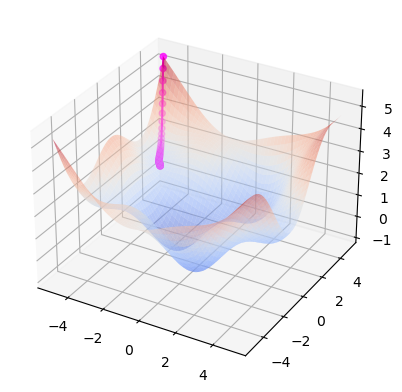

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Define the complex function
def f(x, y):
    return np.sin(x) * np.cos(y) + 0.1 * (x**2 + y**2)

# Gradient of the function
def gradient(x, y):
    df_dx = np.cos(x) * np.cos(y) + 0.2 * x
    df_dy = -np.sin(x) * np.sin(y) + 0.2 * y
    return np.array([df_dx, df_dy])

# Parameters for gradient descent
learning_rate = 0.1
num_iterations = 50

# Initialize starting point for gradient descent
x0, y0 = -5, 5

# Generate data for the surface plot
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.5)

# Lists to store the points during gradient descent
points = [[x0, y0]]

# Perform gradient descent
for i in range(num_iterations):
    grad = gradient(x0, y0)
    x0, y0 = x0 - learning_rate * grad[0], y0 - learning_rate * grad[1]
    points.append([x0, y0])

points = np.array(points)
z_points = f(points[:, 0], points[:, 1])

# Initialize scatter plot and line for gradient descent points
scatter = ax.scatter(points[0, 0], points[0, 1], z_points[0], color='fuchsia')
line, = ax.plot(points[:1, 0], points[:1, 1], z_points[:1], color='fuchsia')

# Function to update the scatter plot and line during animation
def update(frame):
    scatter._offsets3d = (points[:frame, 0], points[:frame, 1], z_points[:frame])
    line.set_data(points[:frame, 0], points[:frame, 1])
    line.set_3d_properties(z_points[:frame])
    return scatter, line,

# Create animation
ani = FuncAnimation(fig, update, frames=num_iterations, interval=200, blit=True)

ani.save('gd.mp4')

<video src="gd.mp4" controls>

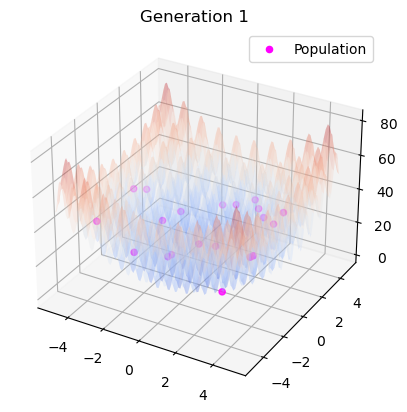

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Parameters for the Genetic Algorithm
population_size = 20
generations = 50
mutation_rate = 0.1
bounds = np.array([[-5, 5], [-5, 5]])  # Bounds for x and y

# Objective function (Rastrigin function)
def objective_function(x):
    return 10 * len(x) + sum([(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in x])

# Create initial population
def create_population(pop_size, bounds):
    population = np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))
    return population

# Evaluate population
def evaluate_population(population):
    return np.array([objective_function(ind) for ind in population])

# Select parents
def select_parents(population, fitness, num_parents):
    parents = population[np.argsort(fitness)][:num_parents]
    return parents

# Crossover
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# Mutation
def mutation(offspring, mutation_rate, bounds):
    for idx in range(offspring.shape[0]):
        for gene_idx in range(offspring.shape[1]):
            if np.random.rand() < mutation_rate:
                random_value = np.random.uniform(bounds[gene_idx, 0], bounds[gene_idx, 1])
                offspring[idx, gene_idx] = random_value
    return offspring

# Genetic Algorithm
def genetic_algorithm(bounds, pop_size, generations, mutation_rate):
    history = []
    population = create_population(pop_size, bounds)
    for gen in range(generations):
        fitness = evaluate_population(population)
        history.append((population.copy(), fitness.copy()))
        parents = select_parents(population, fitness, int(pop_size / 2))
        offspring_size = (pop_size - parents.shape[0], bounds.shape[0])
        offspring = crossover(parents, offspring_size)
        offspring = mutation(offspring, mutation_rate, bounds)
        population[parents.shape[0]:] = offspring
    return history

# Run the Genetic Algorithm
history = genetic_algorithm(bounds, population_size, generations, mutation_rate)

# 3D Visualization setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(bounds[0, 0], bounds[0, 1], 100)
y = np.linspace(bounds[1, 0], bounds[1, 1], 100)
X, Y = np.meshgrid(x, y)
Z = objective_function([X, Y])

# Plot the surface
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6, edgecolor='none')

# Update function for the animation
def update_3d(num, history, ax):
    ax.cla()
    ax.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.2, edgecolor='none')
    population, fitness = history[num]
    ax.scatter(population[:, 0], population[:, 1], fitness, c='fuchsia', label='Population')
    ax.set_title(f'Generation {num+1}')
    ax.legend()

ani = animation.FuncAnimation(fig, update_3d, frames=generations, fargs=(history, ax), interval=200, repeat=False)
ani.save('genetic.mp4')



<video src="genetic.mp4" controls>

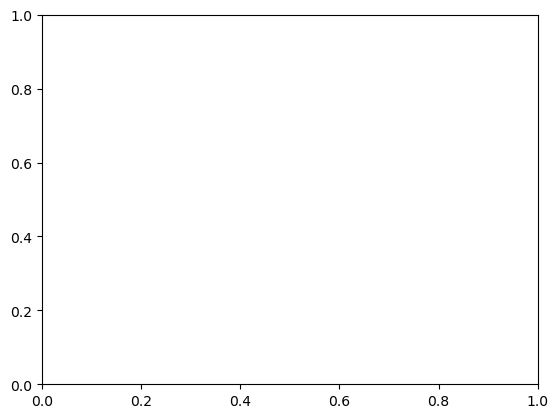

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Parameters for the Genetic Algorithm
population_size = 20
generations = 50
mutation_rate = 0.1
bounds = np.array([[-5, 5], [-5, 5]])  # Bounds for x and y

# Objective function (Rastrigin function)
def objective_function(x):
    return 10 * len(x) + sum([(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in x])

# Create initial population
def create_population(pop_size, bounds):
    population = np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))
    return population

# Evaluate population
def evaluate_population(population):
    return np.array([objective_function(ind) for ind in population])

# Select parents
def select_parents(population, fitness, num_parents):
    parents = population[np.argsort(fitness)][:num_parents]
    return parents

# Crossover
def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1] / 2)
    for k in range(offspring_size[0]):
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# Mutation
def mutation(offspring, mutation_rate, bounds):
    for idx in range(offspring.shape[0]):
        for gene_idx in range(offspring.shape[1]):
            if np.random.rand() < mutation_rate:
                random_value = np.random.uniform(bounds[gene_idx, 0], bounds[gene_idx, 1])
                offspring[idx, gene_idx] = random_value
    return offspring

# Genetic Algorithm
def genetic_algorithm(bounds, pop_size, generations, mutation_rate):
    history = []
    population = create_population(pop_size, bounds)
    for gen in range(generations):
        fitness = evaluate_population(population)
        history.append((population.copy(), fitness.copy()))
        parents = select_parents(population, fitness, int(pop_size / 2))
        offspring_size = (pop_size - parents.shape[0], bounds.shape[0])
        offspring = crossover(parents, offspring_size)
        offspring = mutation(offspring, mutation_rate, bounds)
        population[parents.shape[0]:] = offspring
    return history

# Run the Genetic Algorithm
history = genetic_algorithm(bounds, population_size, generations, mutation_rate)

# 2D Visualization setup
fig, ax = plt.subplots()
x = np.linspace(bounds[0, 0], bounds[0, 1], 100)
y = np.linspace(bounds[1, 0], bounds[1, 1], 100)
X, Y = np.meshgrid(x, y)
Z = objective_function([X, Y])

# Update function for the animation
def update(num, history, ax):
    ax.cla()
    ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    population, fitness = history[num]
    ax.scatter(population[:, 0], population[:, 1], c='red', label='Population')
    ax.set_title(f'Generation {num+1}')
    ax.legend()

ani = animation.FuncAnimation(fig, update, frames=generations, fargs=(history, ax), interval=200, repeat=False)
ani.save('genetic_2d.mp4')


<video src="genetic_2d.mp4" controls>

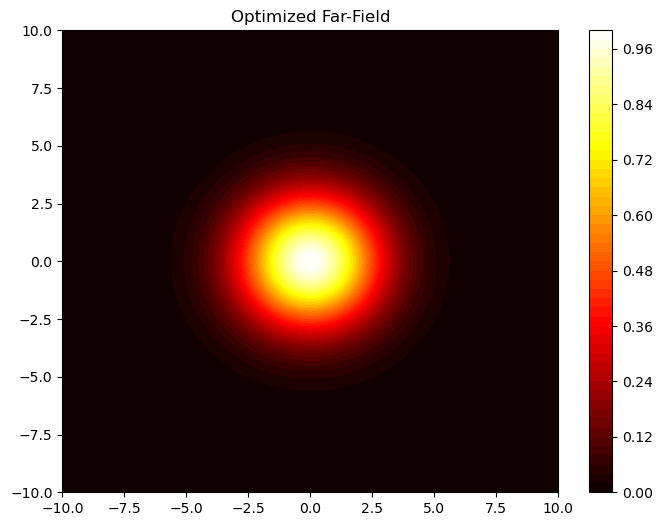

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for the Gaussian beam far-field
size = 1000
sigma = 2.0

# Create a grid of points
x = np.linspace(-10, 10, size)
y = np.linspace(-10, 10, size)
X, Y = np.meshgrid(x, y)

# Calculate the Gaussian beam intensity distribution
Z = np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# Plot the intensity distribution
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='hot')
plt.colorbar()
plt.title('Optimized Far-Field')
plt.savefig('example_farfiled')


/var/folders/9t/wltz5rw540dg7_k5xs930j_c0000gn/T/ipykernel_45256/1737393089.py:53: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  point.set_data(points[i, 0], points[i, 1])


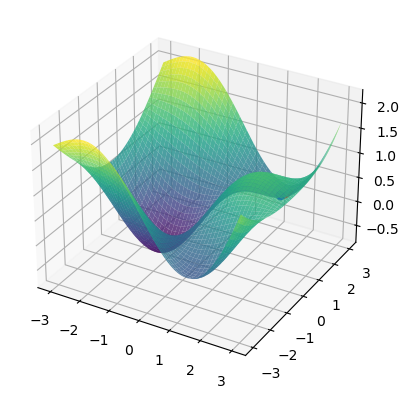

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Define the complex function
def complex_function(x, y):
    return np.sin(x) * np.cos(y) + 0.1 * (x**2 + y**2)

# Gradient of the function
def gradient(x, y):
    df_dx = np.cos(x) * np.cos(y) + 0.2 * x
    df_dy = -np.sin(x) * np.sin(y) + 0.2 * y
    return np.array([df_dx, df_dy])

# Gradient Descent Parameters
learning_rate = 0.1
iterations = 100
x_start, y_start = 2.0, 2.0

# Perform Gradient Descent
points = np.zeros((iterations, 2))
x, y = x_start, y_start
for i in range(iterations):
    grad = gradient(x, y)
    x -= learning_rate * grad[0]
    y -= learning_rate * grad[1]
    points[i] = [x, y]

# Create the mesh grid for the plot
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)
Z = complex_function(X, Y)

# Plot and animate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
path, = ax.plot([], [], [], 'r-', lw=2)
point, = ax.plot([], [], [], 'bo')

def init():
    path.set_data([], [])
    path.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return path, point

def animate(i):
    path.set_data(points[:i+1, 0], points[:i+1, 1])
    path.set_3d_properties(complex_function(points[:i+1, 0], points[:i+1, 1]))
    point.set_data(points[i, 0], points[i, 1])
    point.set_3d_properties(complex_function(points[i, 0], points[i, 1]))
    return path, point

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=iterations, interval=100, blit=True)

ani.save('gd.mp4')
